In [1]:
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    %env DISPLAY = : 1

In [2]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing as mp
from itertools import product
from tqdm import tqdm_notebook

%matplotlib inline

env = gym.make("Taxi-v2")
env.reset()
env.render()

/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [3]:
n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i" % (n_states, n_actions))

n_states=500, n_actions=6


In [4]:
def generate_session(policy, t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states, actions = [], []
    total_reward = 0.

    s = env.reset()

    for t in range(t_max):

        a = np.random.choice(np.arange(n_actions), p=policy[s])

        new_s, r, done, info = env.step(a)

        # Record state, action and add up reward to states,actions and total_reward accordingly.
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break
    return states, actions, total_reward

In [5]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = []
    elite_actions = []
    
    for i,r in enumerate(rewards_batch):
        if r >= reward_threshold:
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])
    
    return elite_states, elite_actions

In [6]:
def update_policy(elite_states, elite_actions):
    """
    Given old policy and a list of elite states/actions from select_elites,
    return new updated policy where each action probability is proportional to

    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]

    Don't forget to normalize policy to get valid probabilities and handle 0/0 case.
    In case you never visited a state, set probabilities for all actions to 1./n_actions

    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions

    """

    new_policy = np.zeros([n_states, n_actions])

    for i,j in zip(elite_states, elite_actions):
        new_policy[i,j] += 1
        
    new_policy[list(set(range(n_states)).difference(elite_states))] = 1
    new_policy /= new_policy.sum(axis=1).reshape((-1,1))
    
    # Don't forget to set 1/n_actions for all actions in unvisited states.

    return new_policy

In [7]:
from IPython.display import clear_output

    
def show_progress(log, percentile=50, clear=False, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    if clear:
        clear_output()
    mean_rewards = log.mean(axis=1)
    thresholds = np.percentile(log, percentile,axis=1)

    print("mean reward = %.3f, threshold=%.3f" % (mean_rewards[-1], thresholds[-1]))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(mean_rewards, label='Mean rewards')
    plt.plot(thresholds, label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(log[-1], range=reward_range)
    plt.vlines([thresholds[-1]],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [8]:
def train_taxi(n_sessions=100, percentile=50, learning_rate=0.5, n_iter=100, pool=None,plot=False):
    
    log = np.zeros([n_iter, n_sessions])
    policy = np.ones([n_states, n_actions])/n_actions
    for i in range(n_iter):

        if pool:
            sessions = list(pool.imap_unordered(generate_session, (policy for _ in range(n_sessions))))
            #sessions = [pool.apply(generate_session,[policy]) for _  in range(n_sessions)]
        else:
            sessions = [generate_session(policy) for _ in range(n_sessions)]
            
        states_batch, actions_batch, rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
        new_policy = update_policy(elite_states, elite_actions)

        policy = learning_rate*new_policy + (1-learning_rate)*policy

        log[i,:] = np.array(rewards_batch)
        # display results on chart
        if plot:
            show_progress(log=log[:i+1], percentile=percentile, clear=True)
        if np.mean(rewards_batch) > 0 :
            break
    return log

for p,n in tqdm_notebook(product(np.linspace(40,90,5),np.linspace(80,160,5).astype('int'))):
    pool = mp.Pool(4)
    print(f"percentile:{p}, n_sessions: {n}")
    log = train_taxi(n_sessions=n, percentile=p, learning_rate=0.5, pool=pool)
    show_progress(log, percentile=p)

pool = mp.Pool(4)
for p in tqdm_notebook(np.linspace(30,60,5)):
    print(f"percentile: {p}")
    log = train_taxi(n_sessions=120, percentile=p, learning_rate=0.5, pool=pool)
    show_progress(log, percentile=p)

In [10]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize, dump, load
from skopt.plots import plot_convergence

In [11]:
space  = [Integer(80, 200, name='n_sessions'),
          Real(30, 60,"uniform", name='percentile'),
          Real(10**-1, 10**0, "uniform", name='learning_rate'),
         ]

In [12]:
@use_named_args(space)
def objective(**params):
    log = train_taxi(pool=pool,n_iter=100,**params)

    return -log[-1].mean()

In [13]:
pool = mp.Pool(4)

In [14]:
res_gp = gp_minimize(objective, space, n_calls=100, random_state=0)
dump(res_gp, './skopt-res')

In [18]:
res_gp = load('./skopt-res')

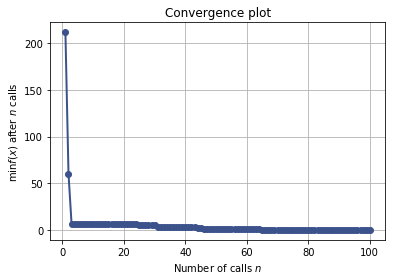

In [19]:
plot_convergence(res_gp);

In [20]:
res_gp.x

[200, 30.0, 0.46415199091294135]

mean reward = -3.470, threshold=1.700


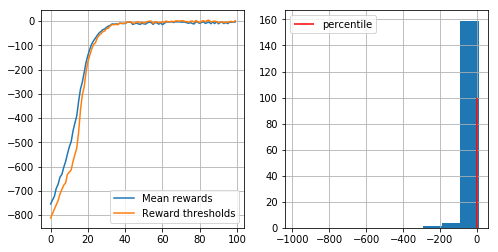

In [21]:
log = train_taxi(n_sessions=200,percentile=30,learning_rate=0.46,n_iter=100,pool=pool,plot=True)

In [23]:
log.mean(axis=1).max()

-1.74